<h2><center>Predicting Home Values in Los Angeles’ South Bay</center></h2>
<h3><center>Springboard | Capstone 1 - In-Depth Analysis</center></h3>
<h4><center>By: Lauren Broussard</center></h4>
---

Using some of our previous findings, we will now use machine learning to see how well we can predict housing prices in the South Bay area. 

As we are looking at a continuous random variable (as opposed to a discrete variable), we'll look at this as a regression problem. Further, since we already have labeled data (features and housing prices), we'll do a Supervised Learning approach. Additionally, we will try to determine which features are most important in predicting home prices in this area. 

For this problem, I'll be using Random Forest Regression, an ensemble method that expands on the Decision Tree approach. 

In [1]:
# import relevant libraries
import numpy as np
import pandas as pd

%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import south_bay dataset 
south_bay = pd.read_csv('../data/processed/south_bay_cleaned.csv', parse_dates = ['SOLD DATE'])

## Data Preparation and Encoding 

#### Drop Columns & Set Dates/Seasons

In [3]:
# drop address and mls number, as these won't work in model
# drop $/square feet as it is based off the price 
south_bay.drop(['ADDRESS','MLS#','$/SQUARE FEET','CITY'], axis=1,inplace=True)

Our 'Sold Date' feature will throw an error if we try to put it in the model, as it's coded as a datetime. We'll break it out into its component parts (year, month, day) as separate columns. Additionally, we'll create a new column called "Season" to further investigate the importance of the relationship between time of year and home price. 

In [4]:
# handle dates 

# create separate date columns for year, month, week number, day
south_bay['SOLD_YEAR'] = south_bay['SOLD DATE'].dt.year
south_bay['SOLD_MONTH'] = south_bay['SOLD DATE'].dt.month
south_bay['SOLD_WEEK'] = south_bay['SOLD DATE'].dt.week
south_bay['SOLD_DAY'] = south_bay['SOLD DATE'].dt.day


# add column - seasons to dataset 
# create dictionary mapping of seasons to months
seasons = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer', 'Summer',\
           'Summer', 'Fall', 'Fall', 'Fall', 'Winter']
month_to_season = dict(zip(range(1,13), seasons))

# map months to seasons and create new column 
south_bay['SEASON'] = south_bay['SOLD DATE'].dt.month.map(month_to_season) 

In [5]:
# drop datetime column 
south_bay.drop(['SOLD DATE'], axis=1,inplace=True)

#### One-Hot Encoding

We'll use one-hot encoding to change categorical columns to binary values before putting them in the model. 

In [6]:
# one hot encoding on all categorical variables
south_bay_f = pd.get_dummies(south_bay)

# Display the first 5 rows of the last columns
south_bay_f.iloc[:,15:].head(5)

,PROPERTY TYPE_Condo/Co-op,PROPERTY TYPE_Mobile/Manufactured Home,PROPERTY TYPE_Single Family Residential,PROPERTY TYPE_Townhouse,NEIGHBORHOOD_Alondra Park,NEIGHBORHOOD_Carson,NEIGHBORHOOD_Del Aire,NEIGHBORHOOD_El Segundo,NEIGHBORHOOD_Florence,NEIGHBORHOOD_Gardena,...,NEIGHBORHOOD_Rolling Hills Estates,NEIGHBORHOOD_San Pedro,NEIGHBORHOOD_Torrance,NEIGHBORHOOD_Watts,NEIGHBORHOOD_Westchester,NEIGHBORHOOD_Wilmington,SEASON_Fall,SEASON_Spring,SEASON_Summer,SEASON_Winter
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


#### Separate Feature Data from Target (Price) Data

In [7]:
# split data into target and features 
X = south_bay_f.drop(['PRICE'],axis=1) # features

y = south_bay_f['PRICE'] # target(price)

In [8]:
# y = np.log(y)

## Random Forest Regression

#### Split into Training and Testing Data

In [9]:
# split data into training and testing 
from sklearn.model_selection import train_test_split 

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [10]:
print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)

Shape of training data: (9541, 51)
Shape of test data: (4090, 51)


#### Establish Baseline

If we were to venture a guess to predict housing prices on each property without any other knowledge, we might guess the median home price. We'll set that as our baseline and see if our model can outperform that. 

In [11]:
# get median price error for test sample
baseline_preds = np.median(y_test)

baseline_errors = round(np.mean(abs(baseline_preds - y_test)),2)

print("Mean Absolute Error (Baseline): {d}".format(d=baseline_errors))

Mean Absolute Error (Baseline): 485739.85


#### Run Initial Random Forest Regressor

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with default values decision trees
randomforest = RandomForestRegressor(random_state = 42)


# Train the model on training data
randomforest.fit(X_train, y_train)

# predict price based on trained model
y_pred = randomforest.predict(X_test)

####  Evaluate Results

In [13]:
from sklearn import metrics

original_mae = metrics.mean_absolute_error(y_test, y_pred)
original_rmse = metrics.mean_squared_error(y_test, y_pred,squared=False)
original_r2 =  metrics.r2_score(y_test, y_pred)

# print metrics: Mean Absolute Error, Root Mean Squared Error, R2
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred,squared=False))
print('R^2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 120915.30442705787
Root Mean Squared Error: 363500.5653406129
R^2 Score: 0.8405623076811706


The mean absolute error indicates that on average, the model predicts homes within about $120,915. This is better than our baseline, but let's see if we can do better. 

Our R<sup>2</sup> score is pretty good at 0.841.

In [14]:
print("Mean Accuracy(Training): {d}".format(d = randomforest.score(X_train,y_train)))
print("Mean Accuracy(Testing): {d}".format(d = randomforest.score(X_test,y_test)))

Mean Accuracy(Training): 0.9728876076911653
Mean Accuracy(Testing): 0.8405623076811707


The training data has an accuracy of 97%, but the accuracy goes down to 0.841 with the testing data. This could suggest some overfitting of the training data. 

Let's look at a scatter plot to see how well we fit the testing data to our predictions. 

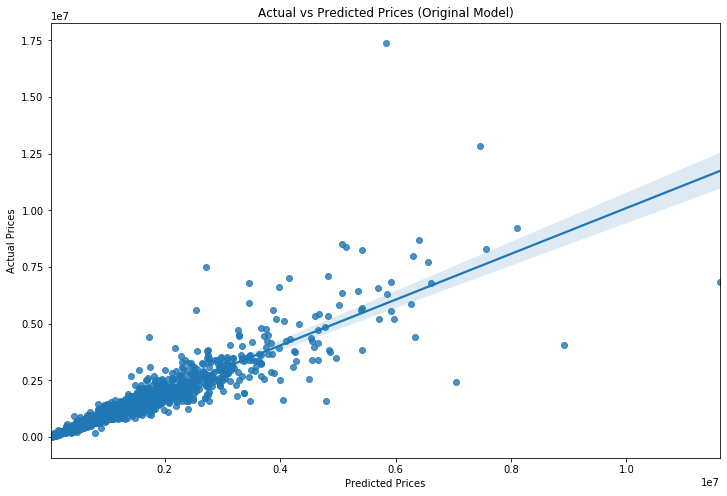

In [15]:
# Plot y_test values vs y_pred values
plt.figure(figsize=(12,8))
sns.regplot(y_pred,y_test)
plt.xlabel('Predicted Prices')
plt.ylabel('Actual Prices')
plt.title("Actual vs Predicted Prices (Original Model)")
plt.show()

We will try to improve the model with parameter tuning and feature selection. 

## Parameter Tuning & Feature Importance

#### Parameter Tuning: max_depth, n_estimators

In [16]:
# tried randomizedsearchcv; not used in final model
'''
# parameter tuning with randomizedsearchcv

%time
# Parameter tuning: n_estimators, max_depth, max_features
from sklearn.model_selection import RandomizedSearchCV

# set up parameter ranges
n_estimators = np.arange(50,700,50)

# Maximum number of levels in tree
max_depth = np.arange(5,50,10)


# set up grid of three parameters
param_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}

print(param_grid)


rf = RandomForestRegressor(random_state=42)

rf_cv = RandomizedSearchCV(rf,param_grid, random_state = 42)


rf_cv.fit(X_train,y_train)


best_params = rf_cv.best_params_

best_ne = best_params.get('n_estimators')
best_max_f = best_params.get('max_features')
best_max_d = best_params.get('max_depth')



# get best parameters
print("The best parameters are:", best_params)
'''

'\n# parameter tuning with randomizedsearchcv\n\n%time\n# Parameter tuning: n_estimators, max_depth, max_features\nfrom sklearn.model_selection import RandomizedSearchCV\n\n# set up parameter ranges\nn_estimators = np.arange(50,700,50)\n\n# Maximum number of levels in tree\nmax_depth = np.arange(5,50,10)\n\n\n# set up grid of three parameters\nparam_grid = {\'max_depth\': max_depth, \'n_estimators\': n_estimators}\n\nprint(param_grid)\n\n\nrf = RandomForestRegressor(random_state=42)\n\nrf_cv = RandomizedSearchCV(rf,param_grid, random_state = 42)\n\n\nrf_cv.fit(X_train,y_train)\n\n\nbest_params = rf_cv.best_params_\n\nbest_ne = best_params.get(\'n_estimators\')\nbest_max_f = best_params.get(\'max_features\')\nbest_max_d = best_params.get(\'max_depth\')\n\n\n\n# get best parameters\nprint("The best parameters are:", best_params)\n'

We'll look to see if we can tune the two parameters for n_estimators and max_depth.

In [17]:
# tune n_estimators

# set up parameter ranges to search over

#commented out for processing time

'''
ne_values = list(np.arange(25,500,25))

highest_score = 0
best_value = 0

for value in ne_values:
    reg = RandomForestRegressor(n_estimators=value,random_state=42)
    reg.fit(X_train,y_train)
    score = reg.score(X_test, y_test)
    if score > highest_score:
        highest_score = score
        best_value = value
print("Best value for {}: {}".format('n_estimators',best_value))
print("Best score: {}".format(score))

best_n_estimator = best_value
'''

best_n_estimator = 450 #result from commented out code above

Best value for n_estimators: 450 \
Best score: 0.8399559292996606

In [18]:
best_n_estimator = 450 #result from cell above

# tune max depth

#commented out for processing time
'''
md_values = list(np.arange(5,30,5))

highest_score = 0
best_value = 0

for value in md_values:
    reg = RandomForestRegressor(n_estimators=best_n_estimator, max_depth=value, random_state=42)
    reg.fit(X_train,y_train)
    score = reg.score(X_test, y_test)
    if score > highest_score:
        highest_score = score
        best_value = value
print("Best value for {}: {}".format('max_depth',best_value))
print("Best score: {}".format(score))

best_max_depth = best_value
'''
best_max_depth = 20 #result from commented out code above

Best value for max_depth: 20
Best score: 0.8403891988258119

#### Feature Importance

Before rerunning the model, we'll turn our attention to feature importance. Below we'll display the top 20 important features to the original model, and its cumulative importance in explaining the model. 

In [19]:
# create function to display df of top 10 most important features
def feat_importance(randomforest,X_train):
    importance = randomforest.feature_importances_
    importance = pd.DataFrame(importance,index=X_train.columns,columns=["Importance"])
    return importance.sort_values(by=['Importance'],ascending=False)

# call function on new model and training data
importance = feat_importance(randomforest,X_train)
importance["Cumul_Imp"] = np.cumsum(importance.Importance)
importance[:20]

,Importance,Cumul_Imp
SQUARE FEET,0.555375,0.555375
LONGITUDE,0.146518,0.701893
LOT SIZE,0.066328,0.768221
NEIGHBORHOOD_Manhattan Beach,0.057531,0.825752
LATITUDE,0.032037,0.857789
YEAR BUILT,0.031089,0.888878
HOA/MONTH,0.012745,0.901624
ZIP OR POSTAL CODE,0.012513,0.914137
NEIGHBORHOOD_Hermosa Beach,0.011445,0.925582
SOLD_DAY,0.010528,0.936110


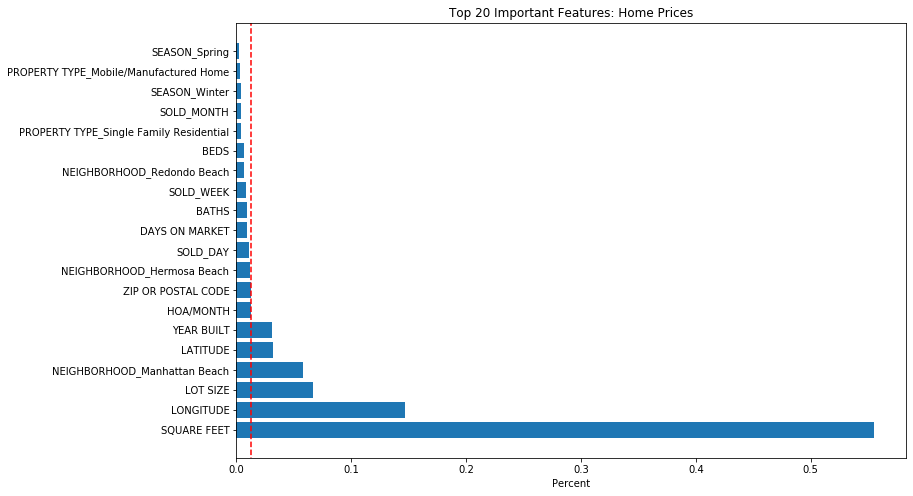

In [20]:
# set threshold for feature importance
cf_threshold = 0.925
subset_x = importance.Importance[importance.Cumul_Imp <= cf_threshold].min()

# plot top important features 
_ = plt.figure(figsize=(12,8))
_ = plt.vlines(x=subset_x,ymin=-10,ymax=30,linestyle='--',color='red')
_ = plt.barh(importance[:20].index, importance[:20].Importance)
_ = plt.title('Top 20 Important Features: Home Prices')
_ = plt.xlabel('Percent')

#### Rerun Model with Optimized Parameters and Most Important Features

Let's rerun the model with the tuned parameters and most important features. 

First, we'll subset our training and test feature data with the features we established as most important above. 

In [21]:
# create list of important features 
important_features = list(importance[importance.Cumul_Imp <= cf_threshold].index)

# print count of important features
print("There are {} features that explain up to {}% of the model.".format(len(important_features),cf_threshold))

# get subset of training and testing data for new smaller set of features  
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

There are 8 features that explain up to 0.925% of the model.


Then, we'll rerun our model. 

In [22]:
# create new Random Forest regressor with new parameters
#randomforest = RandomForestRegressor(n_estimators = best_ne, max_features = best_max_f \
#                                     max_depth = best_max_d, random_state = 42)

randomforest = RandomForestRegressor(n_estimators = best_n_estimator, max_depth = best_max_depth, random_state = 42)


# train the model with shorter list of features
randomforest.fit(X_train_important, y_train)

# predict on test data
y_pred2 = randomforest.predict(X_test_important)

#### Updated Evaluation Scores

In [23]:
updated_mae = metrics.mean_absolute_error(y_test, y_pred2)
updated_rmse = metrics.mean_squared_error(y_test, y_pred2,squared=False)
updated_r2 = metrics.r2_score(y_test, y_pred2)

# print metrics: Mean Absolute Error, Root Mean Squared Error, R2
print('Mean Absolute Error:', updated_mae)
print('Root Mean Squared Error:', updated_rmse)
print('R^2 Score:', updated_r2)

Mean Absolute Error: 121039.87868144999
Root Mean Squared Error: 356955.66812707327
R^2 Score: 0.8462520323663745


### Visualize Results

In [24]:
# plot accuracy scores from first to second model 
models = pd.DataFrame({'model': ['original', 'updated'], 
                                 'mean absolute error':  [original_mae, updated_mae],
                                 'root mean squared error': [original_rmse, updated_rmse],
                                 'r-square score': [original_r2, updated_r2]})

In [25]:
# transpose dataframe, make model type the column headings, 
# and add a column that calculates the difference between the two models
diff = models.transpose()
diff.columns = diff.iloc[0]
diff = diff.drop(diff.index[0])
diff['difference'] = diff.updated - diff.original
diff

model,original,updated,difference
mean absolute error,120915,121040,124.574
root mean squared error,363501,356956,-6544.9
r-square score,0.840562,0.846252,0.00568972


In [26]:
def plot_score_diffs(score_type):
    '''Function to draw plots of score differences'''

# plot type between original and updated model 
    ax = sns.barplot(x='model', y=score_type, hue='model', data=models)
    _ = plt.hlines(y=models[score_type][0],xmin=-.5,xmax=1.7,linestyle='--',color='red')
    _ = plt.legend(loc='center')
    _ = plt.title("{}: \nOriginal vs Updated Model".format(score_type.title()))

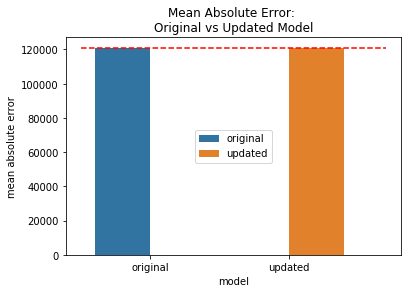

In [27]:
# plot mean absolute error differences
plot_score_diffs('mean absolute error')

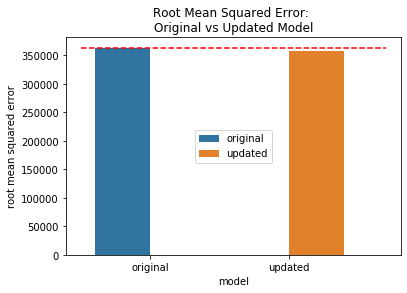

In [28]:
# plot root mean squared error differences
plot_score_diffs('root mean squared error')

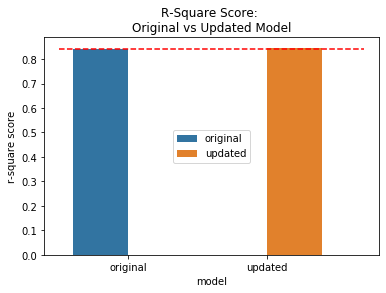

In [29]:
# plot r-squared differences
plot_score_diffs('r-square score')

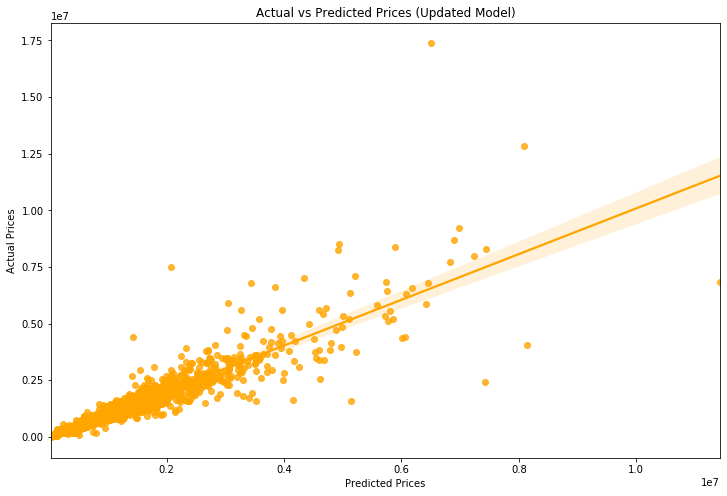

In [30]:
# Plot y_test values vs y_pred values
plt.figure(figsize=(12,8))
sns.regplot(y_pred2,y_test,color='orange')
plt.xlabel('Predicted Prices')
plt.ylabel('Actual Prices')
plt.title("Actual vs Predicted Prices (Updated Model)")
plt.show()

Finally, let's look at a few examples of properties and our predictions made. The best prediction was off by less than $1,220, while the least accurate prediction was off by more than 5 million dollars (the actual price was approximately 17 million, and the predicted price was around 11 million). 

In [31]:
# create DataFrame of predictions vs actual prices
preds_df = pd.DataFrame({'prediction': y_pred2, 'actual': y_test, 'difference': y_pred2 - y_test})

In [32]:
# sample predictions and differences
preds_df.head().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,prediction,actual,difference
9928,240293.080000,588000.000000,-347706.920000
6157,440421.275371,430000.000000,10421.275371
3289,646279.091111,549000.000000,97279.091111
13324,753800.667917,745000.000000,8800.667917
5479,2857484.202469,1700000.000000,1157484.202469


Let's look at an example of a relatively good prediction. 

In [33]:
# prices for predictions with < 15,000 difference
preds_df[abs(preds_df['difference']) <= 15000].apply(lambda s:s.apply(lambda x:\
                                                                      format(x, 'f'))).head()                                                           



,prediction,actual,difference
6157,440421.275371,430000.000000,10421.275371
13324,753800.667917,745000.000000,8800.667917
13220,589143.519401,580000.000000,9143.519401
2337,155859.007160,145000.000000,10859.007160
11554,408139.193314,400000.000000,8139.193314


In [34]:
south_bay.iloc[[13324]]

,PROPERTY TYPE,PRICE,ZIP OR POSTAL CODE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,HOA/MONTH,LATITUDE,LONGITUDE,NEIGHBORHOOD,SOLD_YEAR,SOLD_MONTH,SOLD_WEEK,SOLD_DAY,SEASON
13324,Single Family Residential,745000,90275,3.0,1.0,1084.0,5450.0,1950,528.0,0.0,33.752526,-118.31188,Rancho Palos Verdes,2018,8,35,28,Summer


The model predicted this home to be $ $753,800, and the actual price was $ $ 745,000 (a 8800 difference). Now, we'll turn to a prediction the model did not do well on. 

In [35]:
# prices for predictions with > 500,000 difference
preds_df[abs(preds_df['difference']) > 500000].apply(lambda s:s.apply(lambda x:\
                                                                      format(x, 'f'))).head() 

,prediction,actual,difference
5479,2857484.202469,1700000.000000,1157484.202469
9141,2860841.939333,3600000.000000,-739158.060667
868,2291057.666667,2900000.000000,-608942.333333
4878,2321258.796296,1635000.000000,686258.796296
4743,3794760.975556,2950000.000000,844760.975556


In [36]:
south_bay.iloc[[5479]]

,PROPERTY TYPE,PRICE,ZIP OR POSTAL CODE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,HOA/MONTH,LATITUDE,LONGITUDE,NEIGHBORHOOD,SOLD_YEAR,SOLD_MONTH,SOLD_WEEK,SOLD_DAY,SEASON
5479,Single Family Residential,1700000,90293,5.0,4.0,4590.0,10166.0,1964,701.0,0.0,33.96152,-118.431393,Playa Del Rey,2018,2,8,20,Winter


The model predicted this home to be $ $2,857,484, and the actual price was $ $ 1,700,000  (a $1,157,484 difference).  

In [37]:
# percentage  of homes predicted within 50,000 
preds_df[abs(preds_df['difference']) <= 50000]['prediction'].count()/len(X_test)

0.521760391198044

Finally, let's plot a histogram of the differences. 

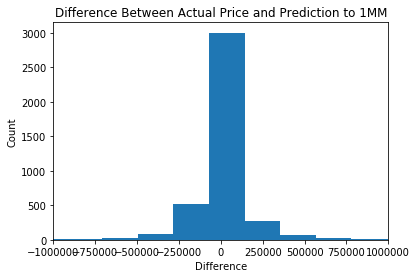

In [38]:
# plot difference in predictions up to 1 million dollars
_ = plt.hist(preds_df['difference'],bins=75)
_ = plt.title('Difference Between Actual Price and Prediction to 1MM')
_ = plt.xlabel('Difference')
_ = plt.ylabel('Count')
_ = plt.xlim(-1000000,1000000)

## Conclusion

We were able to beat our original baseline by more than $300,000, but tuning parameters only increased our accuracy by a small amount. The model seems to make fairly good predictions up to a certain price point, but does not predict all that well for others. This is apparent from the various points that do not fit the regression. In future iterations, we can look at other parameters that we may tune, or other algorithms that may get a better fit. 